In [1]:
from skbio.stats.ordination import OrdinationResults
import pandas as pd
import numpy as np
from plane import distance_to_reference_plane
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
metadata = pd.read_csv('15093_analysis_mapping.txt.gz', compression='gzip', sep='\t', dtype=str)
metadata.set_index('#SampleID', inplace=True)

In [3]:
pcoa_fp = 'ordination.txt.gz'
pcoa = OrdinationResults.read(pcoa_fp, compression='gzip')

metadata['distance_to_plane'] = distance_to_reference_plane(pcoa, metadata, 'HC', 'diagnosis_simple')

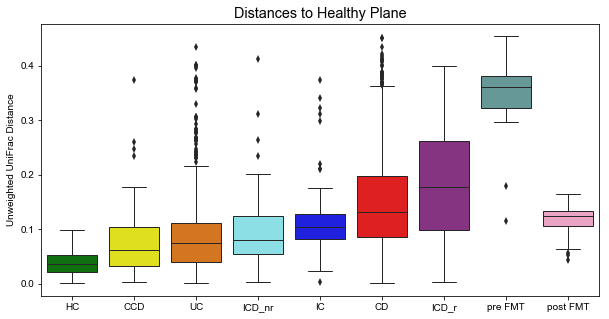

In [4]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)


color_palette = {'HC': '#008000', 'CCD': '#ffff00', 'UC': '#f27304', 'ICD_nr': '#7cecf4', 
                 'IC': '#0000ff', 'CD': '#FF0000', 'ICD_r': '#91278d', 
                 'pre FMT': '#5da09e', 'post FMT': '#f49ac2'}
sns.boxplot(x='diagnosis_simple', y='distance_to_plane', data=metadata, 
            order=['HC', 'CCD', 'UC', 'ICD_nr', 'IC', 'CD', 'ICD_r', 'pre FMT', 'post FMT'],
            linewidth=1, ax=axs, palette=color_palette)
axs.set(title = 'Distances to Healthy Plane', ylabel='Unweighted UniFrac Distance', xlabel="")
fig.savefig("dianosis_simpe.pdf")